In [67]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

pip install optuna

pip install optuna-integration[lightgbm]

pip install category_encoders

pip install imbalanced-learn

pip install lightgbm --upgrade

In [73]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import zipfile
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import optuna
from optuna.integration import LightGBMPruningCallback
import category_encoders as ce
from imblearn.over_sampling import SMOTE

# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

import joblib


df_train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")

# Import and Load the Dataset

# Extract the uploaded zip file
#zip_file_path = 'playground-series-s4e10.zip'
#extract_dir = 'playground-series-s4e10/'

#zip_file_path = '../Data/playground-series-s4e10.zip'
extract_dir = '../Data/playground-series-s4e10'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [78]:
# Load the datasets
df_train = pd.read_csv('../PROJECT/Data/train.csv')
df_test = pd.read_csv('../PROJECT/Data/test.csv')
#sample_submission_df = pd.read_csv(os.path.join(extract_dir, 'sample_submission.csv'))

In [79]:
df_train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [80]:
df_test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


# Inspect the data

In [82]:
#Checking the dimensions of the data
print("Training Data Shape :", df_train.shape)
print("Testing Data Shape :", df_test.shape)

Training Data Shape : (58645, 13)
Testing Data Shape : (39098, 12)


In [83]:
#Knowing the types of feature variables 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

Column Types:

Integer Columns (int64): 6 columns
Float Columns (float64): 3 columns
Categorical Columns (object): 4 columns

In [85]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  object 
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  object 
 6   loan_grade                  39098 non-null  object 
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  object 
 11  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.6+ MB


In [86]:
# Reset index to 'id' for both datasets
df_train.set_index('id', inplace=True)
df_test.set_index('id', inplace=True)

In [87]:
df_train.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


Insights:
Outliers and Data Quality:

person_age (123 years) and person_emp_length (123 years) have unrealistic values, requiring data cleansing or imputation.
Extreme values in person_income and loan_percent_income may influence model training and require scaling or clipping.

Target Class Imbalance:

Loan approvals are significantly fewer than rejections, which requires handling during model training (e.g., using oversampling or class weights).
Feature Distributions:

Income and loan amount distributions are skewed, suggesting the need for log transformation or scaling.
Loan interest rates and credit history lengths appear reasonably distributed.
Economic Feasibility:

Loans consuming a high proportion of income (e.g., >50%) are rare but may indicate high financial risk.

In [89]:
df_test.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,39098.000000,3.909800e+04,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000
mean,27.566781,6.406046e+04,4.687068,9251.466188,10.661216,0.159573,5.830707
std,6.032761,3.795583e+04,3.868395,5576.254680,3.020220,0.091633,4.072157
min,20.000000,4.000000e+03,0.000000,700.000000,5.420000,0.000000,2.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,30.000000,7.588500e+04,7.000000,12000.000000,12.990000,0.210000,8.000000
max,94.000000,1.900000e+06,42.000000,35000.000000,22.110000,0.730000,30.000000


In [90]:
df_train.describe(include=['O']).T

,count,unique,top,freq
person_home_ownership,58645,4,RENT,30594
loan_intent,58645,6,EDUCATION,12271
loan_grade,58645,7,A,20984
cb_person_default_on_file,58645,2,N,49943


In [91]:
# print duplicates
print("Number of duplicates: ", df_train.duplicated().sum())
print("Unique values per column:")
df_train.nunique()

Number of duplicates:  0
Unique values per column:


person_age                      53
person_income                 2641
person_home_ownership            4
person_emp_length               36
loan_intent                      6
loan_grade                       7
loan_amnt                      545
loan_int_rate                  362
loan_percent_income             61
cb_person_default_on_file        2
cb_person_cred_hist_length      29
loan_status                      2
dtype: int64

In a nutshell, loan_status = 1 means the applicant has a tendency to be defaulter. So in that case the committee should consider REJECTING the application.
0 - Loan approved and 1 - Loan not approved. So, in this competition we will be predicting the probability of the loan application getting rejected.
loan_status refers to whether the loan is (will be?) in a state of default, with 1=Default and 0=Non-default.

https://www.kaggle.com/competitions/playground-series-s4e10/discussion/536981

In [93]:
df_train['loan_status'].value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

In [94]:
df_train['person_home_ownership'].value_counts()

person_home_ownership
RENT        30594
MORTGAGE    24824
OWN          3138
OTHER          89
Name: count, dtype: int64

In [95]:
print('Training Data shape before set_index :', df_train.shape)
print('Testing Data shape before set_index:', df_test.shape)

Training Data shape before set_index : (58645, 12)
Testing Data shape before set_index: (39098, 11)


In [96]:
print('Training Data:', df_train.shape)
print('Testing Data:', df_test.shape)

Training Data: (58645, 12)
Testing Data: (39098, 11)


In [97]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [98]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, 58645 to 97742
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.6+ MB


In [99]:
# Identify categorical and numerical features
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
                      'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']


# Feature Engineering: Create new features
def feature_engineering(df):
    # Income to loan amount ratio
    df['income_loan_ratio'] = df['person_income'] / df['loan_amnt']
    # Employment length to age ratio
    df['emp_age_ratio'] = df['person_emp_length'] / df['person_age']
    # Interest rate to income ratio
    df['int_rate_income_ratio'] = df['loan_int_rate'] / df['person_income']
    # Credit history length to age ratio
    df['cred_hist_age_ratio'] = df['cb_person_cred_hist_length'] / df['person_age']
    return df

In [101]:
# Feature Engineering: Create new features
def feature_engineering_1(df):  #CB
# featrue engineering
    df['income_loan_ratio'] = df['person_income'] / df['loan_amnt']
    df['person_emp_length_to_person_age'] = df['person_emp_length'] / df['person_age']
    df['int_rate_income_ratio'] = df['loan_int_rate'] / df['person_income']
    df['cred_hist_age_ratio'] = df['cb_person_cred_hist_length'] / df['person_age']
    df["loan_percent_income_to_income"] = df["loan_percent_income"] / df["person_income"]
    df['person_age_to_person_income'] = df['person_age'] / df['person_income']
    df['loan_int_rate_to_loan_amnt'] = df['loan_int_rate'] / df['loan_amnt']
    return df

In [102]:
df_train = feature_engineering_1(df_train)
df_test = feature_engineering_1(df_test)

In [103]:
print('Training Data Shape afer feature eng:', df_train.shape)
print('Testing Data Shape after feature eng:', df_test.shape)

Training Data Shape afer feature eng: (58645, 19)
Testing Data Shape after feature eng: (39098, 18)


In [104]:
# Update numerical features with new features
numerical_features.extend(['income_loan_ratio', 'person_emp_length_to_person_age', 'int_rate_income_ratio', 'cred_hist_age_ratio', 'loan_percent_income_to_income', 'person_age_to_person_income', 'loan_int_rate_to_loan_amnt'])


In [105]:
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,income_loan_ratio,person_emp_length_to_person_age,int_rate_income_ratio,cred_hist_age_ratio,loan_percent_income_to_income,person_age_to_person_income,loan_int_rate_to_loan_amnt
id,,,,,,,,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0,5.833333,0.000000,0.000328,0.378378,0.000005,0.001057,0.001915
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0,14.000000,0.272727,0.000238,0.090909,0.000001,0.000393,0.003337
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0,4.800000,0.275862,0.000309,0.344828,0.000007,0.001007,0.001483
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0,5.833333,0.466667,0.000159,0.166667,0.000002,0.000429,0.000926
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0,10.000000,0.090909,0.000115,0.136364,0.000002,0.000367,0.001153


In [106]:
df_test.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,income_loan_ratio,person_emp_length_to_person_age,int_rate_income_ratio,cred_hist_age_ratio,loan_percent_income_to_income,person_age_to_person_income,loan_int_rate_to_loan_amnt
id,,,,,,,,,,,,,,,,,,
58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2,2.760000,0.130435,0.000228,0.086957,0.000005,0.000333,0.000630
58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4,9.600000,0.230769,0.000132,0.153846,0.000001,0.000271,0.001268
58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2,7.500000,0.192308,0.000573,0.076923,0.000004,0.000867,0.004298
58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7,7.142857,0.121212,0.000178,0.212121,0.000003,0.000660,0.001271
58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4,6.800000,0.307692,0.000160,0.153846,0.000001,0.000255,0.001088


In [107]:
df_train.to_csv("df_train.csv")
df_test.to_csv("df_test.csv")

In [108]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   person_age                       58645 non-null  int64  
 1   person_income                    58645 non-null  int64  
 2   person_home_ownership            58645 non-null  object 
 3   person_emp_length                58645 non-null  float64
 4   loan_intent                      58645 non-null  object 
 5   loan_grade                       58645 non-null  object 
 6   loan_amnt                        58645 non-null  int64  
 7   loan_int_rate                    58645 non-null  float64
 8   loan_percent_income              58645 non-null  float64
 9   cb_person_default_on_file        58645 non-null  object 
 10  cb_person_cred_hist_length       58645 non-null  int64  
 11  loan_status                      58645 non-null  int64  
 12  income_loan_ratio      

In [109]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, 58645 to 97742
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   person_age                       39098 non-null  int64  
 1   person_income                    39098 non-null  int64  
 2   person_home_ownership            39098 non-null  object 
 3   person_emp_length                39098 non-null  float64
 4   loan_intent                      39098 non-null  object 
 5   loan_grade                       39098 non-null  object 
 6   loan_amnt                        39098 non-null  int64  
 7   loan_int_rate                    39098 non-null  float64
 8   loan_percent_income              39098 non-null  float64
 9   cb_person_default_on_file        39098 non-null  object 
 10  cb_person_cred_hist_length       39098 non-null  int64  
 11  income_loan_ratio                39098 non-null  float64
 12  person_emp_length_t

In [110]:
# Separate features and target
X = df_train.drop(columns='loan_status')
y = df_train['loan_status']


In [111]:
print('Training Data shape before Target Encoding :', df_train.shape)
print('Testing Data shape before Target Encoding:', df_test.shape)

Training Data shape before Target Encoding : (58645, 19)
Testing Data shape before Target Encoding: (39098, 18)


In [112]:
# Initialize Target Encoder
target_enc = ce.TargetEncoder(cols=categorical_features)


In [113]:
print('Training Data shape before Target Encoding :', df_train.shape)
print('Testing Data shape before Target Encoding:', df_test.shape)

Training Data shape before Target Encoding : (58645, 19)
Testing Data shape before Target Encoding: (39098, 18)


In [114]:
print('X shape before Optuna :', X.shape)
print('y shape before Optuna :', y.shape)

X shape before Optuna : (58645, 18)
y shape before Optuna : (58645,)


In [115]:
# Initialize TargetEncoder
target_enc = ce.TargetEncoder(cols=categorical_features)

# Stratified K-Fold for preserving class distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize StandardScaler
scaler = StandardScaler()

# To store the transformed data
X_encoded_scaled = pd.DataFrame(index=X.index, columns=X.columns)

# Perform target encoding and scaling using cross-validation
for train_index, valid_index in skf.split(X, y):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # Fit the target encoder on training data
    target_enc.fit(X_train[categorical_features], y_train)
    
    # Transform both training and validation data
    X_train_encoded = X_train.copy()
    X_valid_encoded = X_valid.copy()
    X_train_encoded[categorical_features] = target_enc.transform(X_train[categorical_features])
    X_valid_encoded[categorical_features] = target_enc.transform(X_valid[categorical_features])
    
    # Fit the scaler on the numerical features of the training set
    scaler.fit(X_train_encoded[numerical_features])
    
    # Scale numerical features
    X_train_encoded[numerical_features] = scaler.transform(X_train_encoded[numerical_features])
    X_valid_encoded[numerical_features] = scaler.transform(X_valid_encoded[numerical_features])
    
    # Save encoded and scaled validation data
    X_encoded_scaled.loc[valid_index, categorical_features] = X_valid_encoded[categorical_features]
    X_encoded_scaled.loc[valid_index, numerical_features] = X_valid_encoded[numerical_features]

 
# Final fit on the entire dataset after cross-validation for consistency
target_enc.fit(X[categorical_features], y)
X_encoded_scaled[categorical_features] = target_enc.transform(X[categorical_features])
scaler.fit(X[numerical_features])
X_encoded_scaled[numerical_features] = scaler.transform(X[numerical_features])

# X_encoded_scaled now contains target-encoded categorical features and scaled numerical features


In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from category_encoders.target_encoder import TargetEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC



C:\Users\monas\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR: Mean AUC = 0.9012, Std AUC = 0.0018
LDA: Mean AUC = 0.8900, Std AUC = 0.0024
KNN: Mean AUC = 0.8396, Std AUC = 0.0047
DCT: Mean AUC = 0.8181, Std AUC = 0.0123
NB: Mean AUC = 0.8891, Std AUC = 0.0030


C:\Users\monas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:29:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\monas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:29:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\monas\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:29:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\monas\anaconda3\Lib\site-packages\

XGB: Mean AUC = 0.9387, Std AUC = 0.0123
RF: Mean AUC = 0.9337, Std AUC = 0.0033
CB: Mean AUC = 0.9509, Std AUC = 0.0045
LGBM: Mean AUC = 0.9511, Std AUC = 0.0042
EXTREE: Mean AUC = 0.9230, Std AUC = 0.0015
SVM: Mean AUC = 0.8680, Std AUC = 0.0042
        Mean AUC   Std AUC
LGBM    0.951112  0.004226
CB      0.950925  0.004533
XGB     0.938680  0.012289
RF      0.933689  0.003251
EXTREE  0.923005  0.001525
LR      0.901238  0.001778
LDA     0.890028  0.002379
NB      0.889093  0.003038
SVM     0.867985  0.004168
KNN     0.839586  0.004664
DCT     0.818062  0.012298


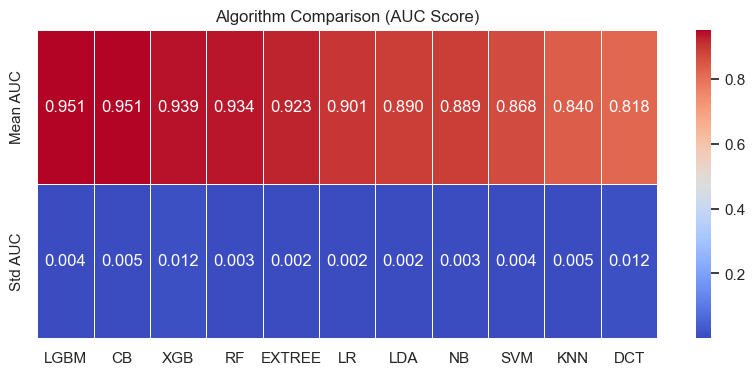

C:\Users\monas\AppData\Local\Temp\ipykernel_2176\1910355990.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_results_df.index, y=model_results_df["Mean AUC"], palette="viridis", edgecolor="black")


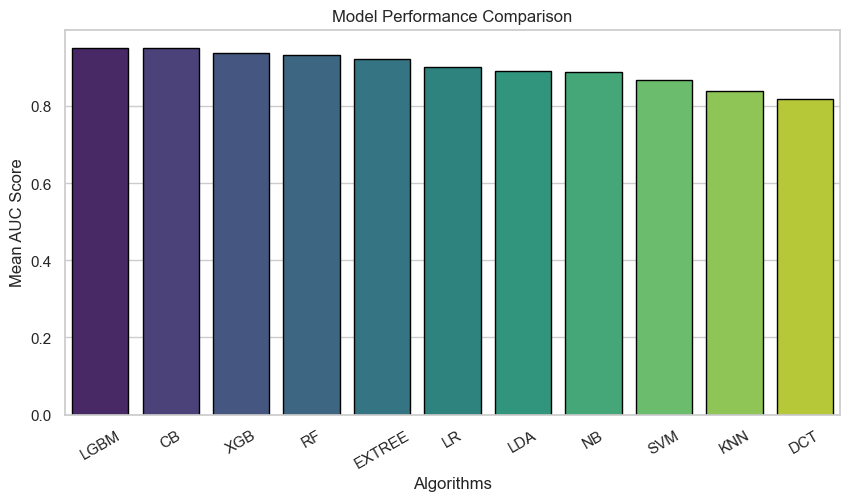

In [117]:
from category_encoders.target_encoder import TargetEncoder
# Load datasets
df_train = pd.read_csv("df_train.csv")
df_test = pd.read_csv("df_test.csv")
# Define categorical and numerical features
categorical_features = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]
numerical_features = [col for col in df_train.columns if col not in categorical_features + ["loan_status", "id"]]

# Separate features and target variable
X_train = df_train.drop(columns=["loan_status", "id"])
y_train = df_train["loan_status"]
X_test = df_test.drop(columns=["id"])

# Initialize encoders and scalers
encoder = TargetEncoder()
scaler = StandardScaler()

# Apply target encoding using cross-validation
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

for cat in categorical_features:
    X_train_encoded[cat] = np.zeros(X_train.shape[0])
    for train_idx, val_idx in skf.split(X_train, y_train):
        encoder.fit(X_train.iloc[train_idx][cat], y_train.iloc[train_idx])
        X_train_encoded.loc[val_idx, cat] = encoder.transform(X_train.iloc[val_idx][cat])
    X_test_encoded[cat] = encoder.fit(X_train[cat], y_train).transform(X_test[cat])

# Scale numerical features
X_train_encoded[numerical_features] = scaler.fit_transform(X_train_encoded[numerical_features])
X_test_encoded[numerical_features] = scaler.transform(X_test_encoded[numerical_features])

# Initialize models
models = [
    ('LR', LogisticRegression()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('KNN', KNeighborsClassifier()),
    ('DCT', DecisionTreeClassifier()),
    ('NB', GaussianNB()),
    ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('RF', RandomForestClassifier(n_estimators=200)),
    ('CB', CatBoostClassifier(verbose=False)),
    ('LGBM', LGBMClassifier(verbosity=-1)),
    ('EXTREE', ExtraTreesClassifier(verbose=False)),
    ('SVM', SVC(probability=True))
]

# Perform model evaluation using Stratified K-Fold Cross Validation
scoring = "roc_auc"
results = []
names = []
model_scores = {}

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
    cv_results = cross_val_score(model, X_train_encoded, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    model_scores[name] = {"Mean AUC": cv_results.mean(), "Std AUC": cv_results.std()}
    print(f"{name}: Mean AUC = {cv_results.mean():.4f}, Std AUC = {cv_results.std():.4f}")

# Convert results to DataFrame
model_results_df = pd.DataFrame(model_scores).T.sort_values(by="Mean AUC", ascending=False)
print(model_results_df)

# --- Visualization ---

# Attractive Table Display
plt.figure(figsize=(10, 4))
sns.heatmap(model_results_df.T, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)
plt.title("Algorithm Comparison (AUC Score)")
plt.show()

# Attractive Bar Chart
plt.figure(figsize=(10, 5))
sns.barplot(x=model_results_df.index, y=model_results_df["Mean AUC"], palette="viridis", edgecolor="black")
plt.xticks(rotation=30)
plt.xlabel("Algorithms")
plt.ylabel("Mean AUC Score")
plt.title("Model Performance Comparison")
plt.show()


LR: 0.901270 (0.004639)
LDA: 0.890101 (0.004855)
KNN: 0.840623 (0.006085)
DCT: 0.831556 (0.007005)
NB: 0.889437 (0.004081)
XGB: 0.950944 (0.002348)
RF: 0.937530 (0.003976)
CB: 0.955009 (0.002907)
LGBM: 0.955261 (0.002824)
EXTREE: 0.924903 (0.004051)


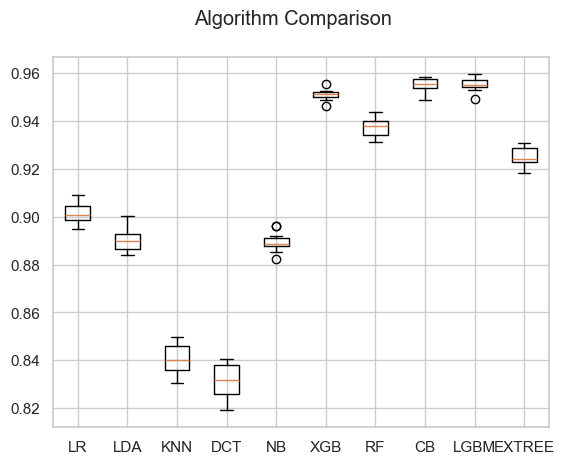

In [118]:
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DCT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('XGB', XGBClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators=200)))
models.append(('CB', CatBoostClassifier(verbose= False)))
models.append(('LGBM', LGBMClassifier(verbosity= -1)))
models.append(('EXTREE', ExtraTreesClassifier(verbose= False)))
##models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'roc_auc' #'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=None)
    cv_results = model_selection.cross_val_score(model, X_encoded_scaled, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

C:\Users\monas\AppData\Local\Temp\ipykernel_2176\3611248776.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=15, fontsize=10)


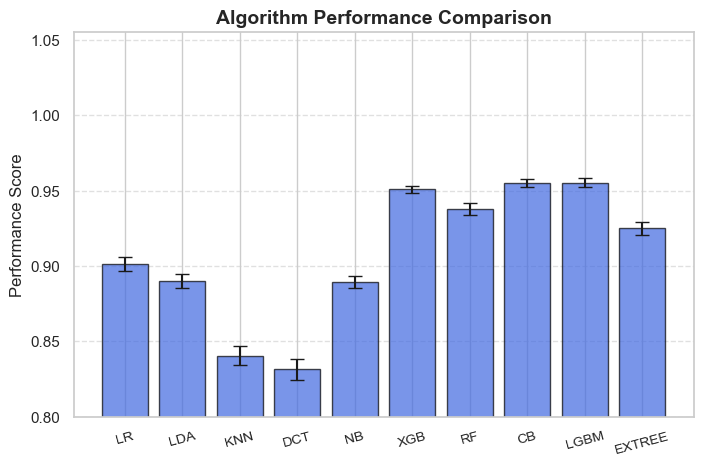

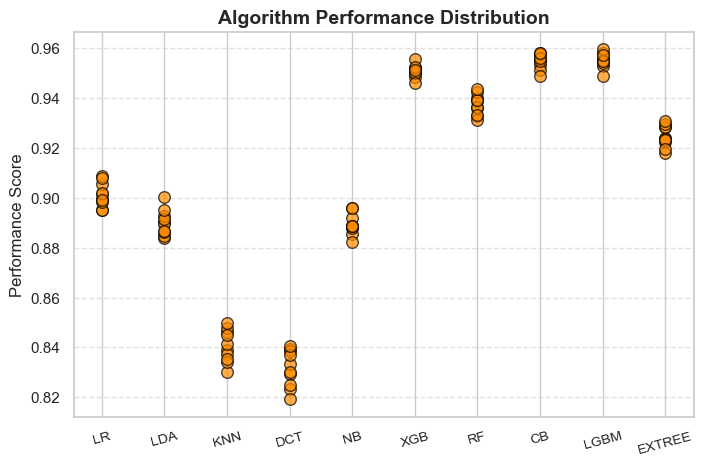

In [119]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with actual results and names)
#names = ["Algo1", "Algo2", "Algo3", "Algo4", "Algo5"]
#results = [np.random.rand(10) for _ in names]  # Simulating results

# Compute means and standard deviations
means = [np.mean(r) for r in results]
stds = [np.std(r) for r in results]

# Attractive Bar Chart
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(names, means, yerr=stds, capsize=5, color='royalblue', alpha=0.7, edgecolor='black')
ax.set_title('Algorithm Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Performance Score', fontsize=12)
ax.set_xticklabels(names, rotation=15, fontsize=10)
ax.set_ylim(0.8, max(means) + 0.1)  # Set y-axis range
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Attractive Scatter Plot
fig, ax = plt.subplots(figsize=(8, 5))
for i, r in enumerate(results):
    x_values = np.full(len(r), i + 1)  # Spreading data around each algorithm index
    ax.scatter(x_values, r, color='darkorange', edgecolors='black', alpha=0.7, s=70)

ax.set_xticks(range(1, len(names) + 1))
ax.set_xticklabels(names, rotation=15, fontsize=10)
ax.set_title('Algorithm Performance Distribution', fontsize=14, fontweight='bold')
ax.set_ylabel('Performance Score', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


C:\Users\monas\AppData\Local\Temp\ipykernel_2176\3670411989.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=15, fontsize=10)


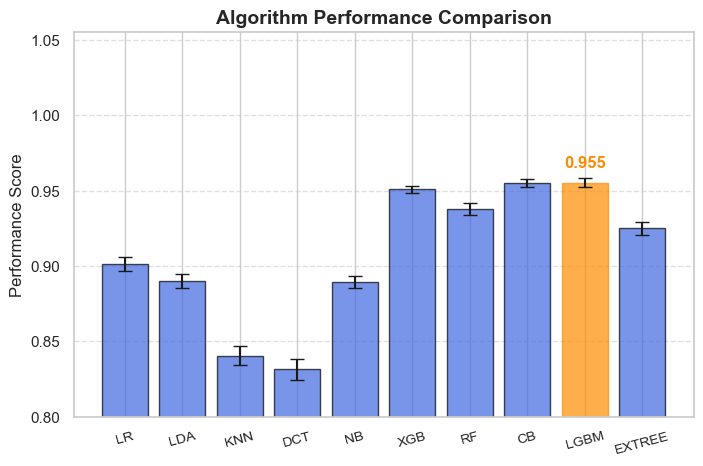

In [120]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (replace with actual results and names)
#names = ["Algo1", "Algo2", "Algo3", "Algo4", "Algo5"]
#results = [np.random.uniform(0.8, 1.0, 10) for _ in names]  # Simulating results within [0.8, 1.0]

# Compute means and standard deviations
means = [np.mean(r) for r in results]
stds = [np.std(r) for r in results]

# Attractive Bar Chart with Y-axis starting from 0.8
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(names, means, yerr=stds, capsize=5, color='royalblue', alpha=0.7, edgecolor='black')
ax.set_title('Algorithm Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('Performance Score', fontsize=12)
ax.set_xticklabels(names, rotation=15, fontsize=10)
ax.set_ylim(0.8, max(means) + 0.1)  # Set y-axis range

# Highlight highest value
max_value = max(means)
max_index = means.index(max_value)
bars[max_index].set_color('darkorange')

# Adding text labels for highest value
ax.text(max_index, max_value + 0.01, f'{max_value:.3f}', ha='center', fontsize=12, fontweight='bold', color='darkorange')

# Adding a grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()


In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example data: 5 algorithms with 10 results each
#names = ["Algo1", "Algo2", "Algo3", "Algo4", "Algo5"]
#results = [np.random.uniform(0.8, 1.0, 10) for _ in names]  # Simulated results

# Compute mean, standard deviation, min, and max
df = pd.DataFrame(results, index=names).T
df_summary = df.agg(["mean", "std", "min", "max"]).T

# Highlight highest values
def highlight_max(s):
    is_max = s == s.max()
    return ["background-color: lightgreen" if v else "" for v in is_max]

# Style the table
styled_table = df_summary.style.apply(highlight_max, subset=["mean", "max"]).format(precision=3)

# Display table
print(df_summary)  # Prints in console
styled_table  # Displays in Jupyter Notebook


            mean       std       min       max
LR      0.901270  0.004890  0.894966  0.908943
LDA     0.890101  0.005117  0.883807  0.900377
KNN     0.840623  0.006414  0.830315  0.849610
DCT     0.831556  0.007384  0.819178  0.840647
NB      0.889437  0.004302  0.882373  0.896135
XGB     0.950944  0.002475  0.946242  0.955635
RF      0.937530  0.004191  0.931230  0.943895
CB      0.955009  0.003065  0.948876  0.958203
LGBM    0.955261  0.002977  0.949056  0.959646
EXTREE  0.924903  0.004270  0.918225  0.930699


,mean,std,min,max
LR,0.901,0.005,0.895,0.909
LDA,0.890,0.005,0.884,0.900
KNN,0.841,0.006,0.830,0.850
DCT,0.832,0.007,0.819,0.841
NB,0.889,0.004,0.882,0.896
XGB,0.951,0.002,0.946,0.956
RF,0.938,0.004,0.931,0.944
CB,0.955,0.003,0.949,0.958
LGBM,0.955,0.003,0.949,0.960
EXTREE,0.925,0.004,0.918,0.931


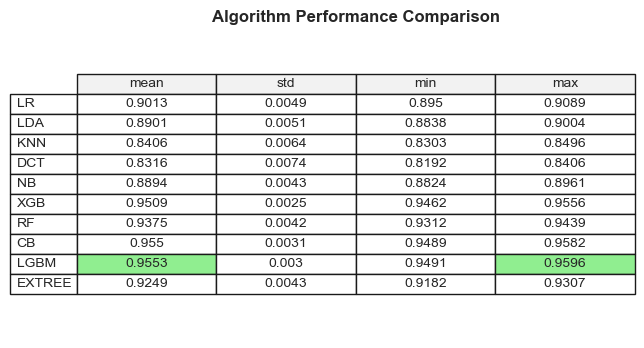

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example data: 5 algorithms with 10 results each
#names = ["Algo1", "Algo2", "Algo3", "Algo4", "Algo5"]
#results = [np.random.uniform(0.8, 1.0, 10) for _ in names]  # Simulated results

# Compute statistics: mean, std, min, max
df = pd.DataFrame(results, index=names).T
df_summary = df.agg(["mean", "std", "min", "max"]).T

# Find the highest values
highest_mean = df_summary["mean"].idxmax()
highest_max = df_summary["max"].idxmax()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_axis_off()

# Create a table
table = ax.table(
    cellText=df_summary.round(4).values,  # Rounded values
    colLabels=df_summary.columns,
    rowLabels=df_summary.index,
    cellLoc="center",
    loc="center",
    colColours=["#f2f2f2"] * len(df_summary.columns),  # Header background color
)

# Style the table
for i, key in enumerate(df_summary.index):
    if key == highest_mean:
        table[i + 1, 0].set_facecolor("lightgreen")  # Highlight highest mean
    if key == highest_max:
        table[i + 1, 3].set_facecolor("lightgreen")  # Highlight highest max

# Improve appearance
table.scale(1.2, 1.2)  # Scale table size
table.auto_set_font_size(False)
table.set_fontsize(10)

plt.title("Algorithm Performance Comparison", fontsize=12, fontweight="bold")
plt.show()


LR: 0.901270 (0.004639)
LDA: 0.890101 (0.004855)
KNN: 0.840623 (0.006085)
DCT: 0.831112 (0.006359)
NB: 0.889437 (0.004081)
XGB: 0.950944 (0.002348)
RF: 0.938134 (0.003726)
CB: 0.955009 (0.002907)
LGBM: 0.955261 (0.002824)
EXTREE: 0.924025 (0.004641)
SVM: 0.868862 (0.007646)


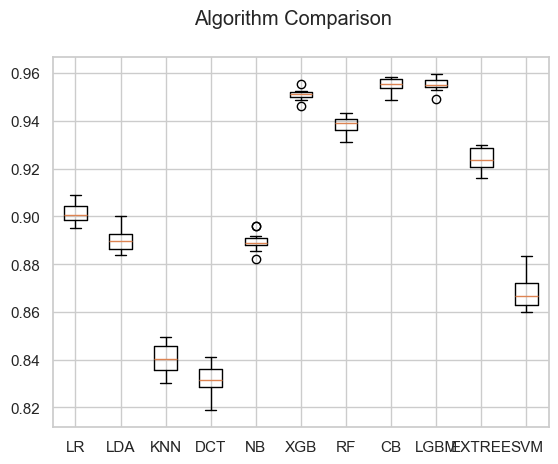

In [123]:
# prepare configuration for cross validation test harness
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DCT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('XGB', XGBClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators=200)))
models.append(('CB', CatBoostClassifier(verbose= False)))
models.append(('LGBM', LGBMClassifier(verbosity= -1)))
models.append(('EXTREE', ExtraTreesClassifier(verbose= False)))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'roc_auc'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=None)
    cv_results = model_selection.cross_val_score(model, X_encoded_scaled, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [124]:
## For Validation Set

In [126]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Create a dictionary to store test set performance
test_results = {}

# Iterate over trained models and evaluate on test data
for name, model in models:
    model.fit(X_encoded_scaled, y)  # Train the model on full training set
    y_pred = model.predict(X_test_encoded)  # Predictions on test set
    y_pred_proba = model.predict_proba(X_test_encoded)[:, 1] if hasattr(model, "predict_proba") else None  # Probabilities (if applicable)

    # Compute metrics
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    acc = accuracy_score(y_test, y_pred)

    # Store results
    test_results[name] = {'Accuracy': acc, 'ROC AUC': auc if auc else "N/A"}

    # Print results
    print(f"{name}: Accuracy={acc:.4f}, ROC AUC={auc:.4f}" if auc else f"{name}: Accuracy={acc:.4f}")

# Convert to DataFrame for easy visualization
import pandas as pd
test_results_df = pd.DataFrame(test_results).T
print(test_results_df)


NameError: name 'y_test' is not defined

In [142]:
df_test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,income_loan_ratio,person_emp_length_to_person_age,int_rate_income_ratio,cred_hist_age_ratio,loan_percent_income_to_income,person_age_to_person_income,loan_int_rate_to_loan_amnt
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2,2.760000,0.130435,0.000228,0.086957,0.000005,0.000333,0.000630
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4,9.600000,0.230769,0.000132,0.153846,0.000001,0.000271,0.001268
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2,7.500000,0.192308,0.000573,0.076923,0.000004,0.000867,0.004298
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7,7.142857,0.121212,0.000178,0.212121,0.000003,0.000660,0.001271
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4,6.800000,0.307692,0.000160,0.153846,0.000001,0.000255,0.001088


In [128]:
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [129]:
# Prepare arrays for out-of-fold predictions
oof_preds = np.zeros(X.shape[0])
test_preds = np.zeros(df_test.shape[0])

In [130]:
# Define objective function for Optuna
def objective(trial):
    aucs = []
    for train_index, valid_index in skf.split(X, y):
        X_train_fold, X_valid_fold = X.iloc[train_index], X.iloc[valid_index]
        y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[valid_index]

        # Target Encoding
        X_train_fold = target_enc.fit_transform(X_train_fold, y_train_fold)
        X_valid_fold = target_enc.transform(X_valid_fold)
        X_test_enc = target_enc.transform(df_test)

        # Handle class imbalance with SMOTE
        sm = SMOTE(random_state=42)
        X_resampled, y_resampled = sm.fit_resample(X_train_fold, y_train_fold)

        #X_resampled, y_resampled = X_train_fold, y_train_fold
        
        # Scale numerical features
        scaler = StandardScaler()
        X_resampled[numerical_features] = scaler.fit_transform(X_resampled[numerical_features])
        X_valid_fold[numerical_features] = scaler.transform(X_valid_fold[numerical_features])
        X_test_enc[numerical_features] = scaler.transform(X_test_enc[numerical_features])

        # Define LightGBM parameters using new suggest methods
        param = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'subsample': trial.suggest_float('subsample', 0.4, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
            'random_state': 42,
            'verbosity': -1,
            'n_jobs': -1,
            #'device': 'cuda',
        }

        lgb_train = lgb.Dataset(X_resampled, y_resampled)
        lgb_valid = lgb.Dataset(X_valid_fold, y_valid_fold, reference=lgb_train)

        # Use early_stopping and log_evaluation as callbacks
        pruning_callback = LightGBMPruningCallback(trial, 'auc')
        early_stopping_callback = lgb.early_stopping(stopping_rounds=100, verbose=False)
        log_eval_callback = lgb.log_evaluation(period=0)  # Suppress logging during optimization

        callbacks = [pruning_callback, early_stopping_callback, log_eval_callback]

        # Include valid_names to ensure the validation dataset is named 'valid_0'
        gbm = lgb.train(
            param,
            lgb_train,
            num_boost_round=10000,
            valid_sets=[lgb_train, lgb_valid],
            valid_names=['training', 'valid_0'],  # Specify names here
            callbacks=callbacks
        )

        y_valid_pred = gbm.predict(X_valid_fold, num_iteration=gbm.best_iteration)
        auc = roc_auc_score(y_valid_fold, y_valid_pred)
        aucs.append(auc)

    return np.mean(aucs)

In [131]:
# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='maximize', study_name='lgbm_classifier')
study.optimize(objective, n_trials=50)

[I 2025-04-10 14:29:07,747] A new study created in memory with name: lgbm_classifier
[W 2025-04-10 14:29:08,003] Trial 0 failed with parameters: {} because of the following error: ValueError('Unexpected input dimension 19, expected 18').
Traceback (most recent call last):
  File "C:\Users\monas\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\monas\AppData\Local\Temp\ipykernel_2176\3608995150.py", line 11, in objective
    X_test_enc = target_enc.transform(df_test)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\monas\anaconda3\Lib\site-packages\sklearn\utils\_set_output.py", line 295, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\monas\anaconda3\Lib\site-packages\category_encoders\utils.py", line 450, in transform
    self._check_transform_inputs(X)
  File "C:\Users\monas\anaconda

ValueError: Unexpected input dimension 19, expected 18

In [ ]:
best_params = study.best_params
print('Best Hyperparameters:')
print(best_params)

Best Hyperparameters:
{'learning_rate': 0.07494066339794482, 'num_leaves': 36, 'max_depth': 4, 'min_child_samples': 80, 'subsample': 0.47232380658590173, 'colsample_bytree': 0.561711350752377, 'reg_alpha': 0.3026778531642185, 'reg_lambda': 0.7583892699023145}

In [ ]:
# Retrieve the best parameters
best_params = study.best_params
best_params['objective'] = 'binary'
best_params['metric'] = 'auc'
best_params['boosting_type'] = 'gbdt'
best_params['random_state'] = 42
best_params['verbosity'] = -1
best_params['n_jobs'] = -1

In [ ]:
print('Best Hyperparameters:')
print(best_params)


Best Hyperparameters:
{'learning_rate': 0.07494066339794482, 'num_leaves': 36, 'max_depth': 4, 'min_child_samples': 80, 'subsample': 0.47232380658590173, 'colsample_bytree': 0.561711350752377, 'reg_alpha': 0.3026778531642185, 'reg_lambda': 0.7583892699023145, 'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'random_state': 42, 'verbosity': -1, 'n_jobs': -1}

In [ ]:
# Train the model with best hyperparameters and make predictions
for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
    print(f'Fold {fold + 1}')
    X_train_fold, X_valid_fold = X.iloc[train_index], X.iloc[valid_index]
    y_train_fold, y_valid_fold = y.iloc[train_index], y.iloc[valid_index]

    # Target Encoding
    X_train_fold = target_enc.fit_transform(X_train_fold, y_train_fold)
    X_valid_fold = target_enc.transform(X_valid_fold)
    X_test_enc = target_enc.transform(df_test)

    # Handle class imbalance with SMOTE
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_train_fold, y_train_fold)

    #X_resampled, y_resampled = X_train_fold, y_train_fold
    
    # Scale numerical features
    scaler = StandardScaler()
    X_resampled[numerical_features] = scaler.fit_transform(X_resampled[numerical_features])
    X_valid_fold[numerical_features] = scaler.transform(X_valid_fold[numerical_features])
    X_test_enc[numerical_features] = scaler.transform(X_test_enc[numerical_features])

    # Save the trained TargetEncoder object
    with open('new_target_encoder.pkl', 'wb') as file:
        pickle.dump(target_enc, file)

    print("Target Encoder saved as 'new target_encoder.pkl'")

    # Save the scaler object
    with open('new_scaler.pkl', 'wb') as file:
        pickle.dump(scaler, file)

    print("Scaler saved as 'new scaler.pkl'")


        

    lgb_train = lgb.Dataset(X_resampled, y_resampled)
    lgb_valid = lgb.Dataset(X_valid_fold, y_valid_fold, reference=lgb_train)

    # Use early_stopping and log_evaluation as callbacks
    early_stopping_callback = lgb.early_stopping(stopping_rounds=100, verbose=False)
    log_eval_callback = lgb.log_evaluation(period=100)

    callbacks = [early_stopping_callback, log_eval_callback]

    # Include valid_names here as well
    gbm = lgb.train(
        best_params,
        lgb_train,
        num_boost_round=10000,
        valid_sets=[lgb_train, lgb_valid],
        valid_names=['training', 'valid_0'],
        callbacks=callbacks
    )

    # Predict on validation set
    y_valid_pred = gbm.predict(X_valid_fold, num_iteration=gbm.best_iteration)
    oof_preds[valid_index] = y_valid_pred

    # Predict on test set
    test_fold_pred = gbm.predict(X_test_enc, num_iteration=gbm.best_iteration)
    test_preds += test_fold_pred / skf.n_splits

In [ ]:
# Evaluate the overall model performance
roc_auc = roc_auc_score(y, oof_preds)
print(f'Overall ROC-AUC Score: {roc_auc}')
#Overall ROC-AUC Score: 0.9578482117185253

In [ ]:
# Prepare the submission file
submission_df = pd.DataFrame({'id': df_test.index, 'loan_status': test_preds})
submission_file_path = 'loan_approval_submission_Mona_New.csv'
submission_df.to_csv(submission_file_path, index=False)

In [ ]:
# Display the first few rows of the submission file
print(submission_df.head())

In [ ]:
joblib.dump(gbm,"new_gbm_model.joblib")

In [ ]:
#pd.to_pickle(df_train,'./df_train.pkl') 